<a href="https://colab.research.google.com/github/mohamedchnafy-ds/python_project/blob/main/project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# %cd '/content/drive/MyDrive/python project/notebooks'
# os.chdir('/content/drive/MyDrive/python project/notebooks')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import sqlalchemy as db
from sqlalchemy import create_engine
import sqlite3
import os
import psycopg2
from urllib.parse import quote_plus
import plotly.express as px
import plotly.io as pio
from matplotlib import pyplot as plt
# install packages ifp !pip install -U --user --proxy http://irsrvpxw1-elv:8082 fsspec pip

 #### Data

In [15]:
os.chdir('/content/drive/MyDrive/python project/')
current_dir = os.path.abspath(os.getcwd())
current_dir

'/content/drive/MyDrive/python project'

In [16]:
path  = current_dir + '/input_data/'

In [19]:
v_prod = pd.ExcelFile(path+'Volve_production_data.xlsx')
print("Feuilles disponibles:", v_prod.sheet_names)
# Lire une feuille après avoir vu les noms
# Je suis entrain de fin
daily = v_prod.parse('Daily Production Data')
monthly = v_prod.parse('Monthly Production Data')
monthly

Feuilles disponibles: ['Daily Production Data', 'Monthly Production Data']


,Wellbore name,NPDCode,Year,Month,On Stream (hrs),Oil (Sm3),Gas (Sm3),Water (Sm3),GI (Sm3),WI (Sm3)
0,15/9-F-1 C,7405,2014,4,227.50000,11142.47,1597936.65,0.00,NaN,NaN
1,15/9-F-1 C,7405,2014,5,733.83334,24901.95,3496229.65,783.48,NaN,NaN
2,15/9-F-1 C,7405,2014,6,705.91666,19617.76,2886661.69,2068.48,NaN,NaN
3,15/9-F-1 C,7405,2014,7,742.41666,15085.68,2249365.75,6243.98,NaN,NaN
4,15/9-F-1 C,7405,2014,8,432.99166,6970.43,1048190.80,4529.75,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
521,15/9-F-5,5769,2016,5,732.00000,9724.40,1534677.16,3949.90,NaN,0.0
522,15/9-F-5,5769,2016,6,718.41667,9121.48,1468557.12,2376.93,NaN,NaN
523,15/9-F-5,5769,2016,7,668.64168,9985.29,1602674.39,2453.71,NaN,0.0
524,15/9-F-5,5769,2016,8,608.42500,8928.90,1417278.51,2371.86,NaN,0.0


In [21]:
# Créer une connexion à la base de données SQLite
engine = create_engine('sqlite:///{}wells_data.db'.format(path))
# Lister toutes les tables de la base de données
with engine.connect() as conn:
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    tables = pd.read_sql_query(query, conn)
    table_names = tables['name'].tolist()

print("Le fichier contient les tables suivantes : {}".format(table_names))

Le fichier contient les tables suivantes : ['wells_data']


#### Conversion de la database en fichier excel

In [26]:
# Créer un writer Excel
with pd.ExcelWriter('/content/drive/MyDrive/python project/output_data/wells_data.xlsx', engine='openpyxl') as writer:
    # Pour chaque table dans la base de données
    for table_name in table_names:
        # Lire la table avec pandas
        df = pd.read_sql_table(table_name, engine)

        # Écrire chaque table dans une feuille différente de l'Excel
        df.to_excel(writer, sheet_name=table_name, index=False)

print("Conversion terminée ! Le fichier output_data.xlsx a été créé.")

Conversion terminée ! Le fichier output_data.xlsx a été créé.


#  local PostgreSQL database

In [ ]:
# Configuration de la base de données PostgreSQL
db_params = {
    'host': 'localhost',
    'database': 'welldata',
    'user': 'postgres',
    'password': 'postgres1',
    'port': '5432'  # Port par défaut de PostgreSQL
}

def excel_to_postgresql(excel_file, table_name, if_exists='replace'):
    try:
        # Lire le fichier Excel
        print(f"Lecture du fichier Excel : {excel_file}")
        df = pd.read_excel(excel_file)

        # Créer la chaîne de connexion PostgreSQL
        password = quote_plus(db_params['password'])  # Échapper les caractères spéciaux
        connection_string = f"postgresql://{db_params['user']}:{password}@{db_params['host']}:{db_params['port']}/{db_params['database']}"

        # Créer la connexion avec SQLAlchemy
        print("Connexion à PostgreSQL...")
        engine = create_engine(connection_string)

        # Envoyer les données vers PostgreSQL
        print(f"Transfert des données vers la table : {table_name}")
        df.to_sql(
            name=table_name,
            con=engine,
            if_exists=if_exists,  # 'replace' pour écraser, 'append' pour ajouter
            index=False,
            schema='public'  # Schéma par défaut
        )

        # Vérifier le nombre de lignes transférées
        with engine.connect() as conn:
            result = conn.execute(f"SELECT COUNT(*) FROM {table_name}")
            count = result.scalar()

        print(f"Transfert réussi ! {count} lignes transférées vers {table_name}")
        return True

    except Exception as e:
        print(f"Erreur lors du transfert : {str(e)}")
        return False

    finally:
        if 'engine' in locals():
            engine.dispose()



In [ ]:
# Utilisation de la fonction
if __name__ == "__main__":
    # Paramètres
    excel_file = 'C://Users//chnafym//OneDrive - ifpen.fr//Desktop//Cours//ENSG//GDM2//python project//output_data//wells_data.xlsx'  # Votre fichier Excel
    table_name = 'wells_data'        # Nom de la table dans PostgreSQL

    # Exécuter le transfert
    excel_to_postgresql(excel_file, table_name, if_exists='replace')

Lecture du fichier Excel : C://Users//chnafym//OneDrive - ifpen.fr//Desktop//Cours//ENSG//GDM2//python project//output_data//wells_data.xlsx
Connexion à PostgreSQL...
Transfert des données vers la table : wells_data
Erreur lors du transfert : (psycopg2.OperationalError) connection to server at "localhost" (::1), port 5432 failed: Connection refused (0x0000274D/10061)
	Is the server running on that host and accepting TCP/IP connections?
connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused (0x0000274D/10061)
	Is the server running on that host and accepting TCP/IP connections?



# Wells Data

In [27]:
current_dir + '/output_data/'+'wells_data.xlsx'

'/content/drive/MyDrive/python project/output_data/wells_data.xlsx'

In [28]:
wells_data1 = pd.ExcelFile(current_dir + '/output_data/'+'wells_data.xlsx')
print("Feuilles disponibles:", wells_data1.sheet_names)
# Lire une feuille après avoir vu les noms

Feuilles disponibles: ['wells_data']


In [29]:
wells_data = wells_data1.parse('wells_data')

In [30]:
wells_data

,index,wlbNpdidWellbore,dscNpdidDiscovery,fldNpdidField,fclNpdidFacilityDrilling,fclNpdidFacilityProducing,wlbNpdidWellboreReclass,prlNpdidProductionLicence,wlbWellboreName,wlbWell,...,wlbSubSea,wlbKickOffPoint,wlbLicenceTargetName,wlbPluggedDate,wlbPluggedAbandonDate,prlNpdidProdLicenceTarget,wlbNpdidSiteSurvey,wlbSiteSurvey,wlbDateReclass,wlbPointGeometryWKT
0,0,28,44990.0,NaN,288280.0,NaN,0,21348.0,7/8-3,7/8-3,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,POINT (2.5460499996279968 57.258494000193025)
1,1,30,NaN,NaN,287848.0,NaN,0,21356.0,7/11-8,7/11-8,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,POINT (2.5295830008933171 57.213871999628537)
2,2,42,44966.0,43792.0,287956.0,NaN,0,21356.0,7/11-5,7/11-5,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,POINT (2.4982029996618897 57.135107999856238)
3,3,57,23296230.0,43785.0,271693.0,NaN,0,20900.0,7/11-7,7/11-7,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,POINT (2.4346719996169637 57.069455999904839)
4,4,149,44960.0,43785.0,296407.0,NaN,0,20900.0,7/11-1,7/11-1,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,POINT (2.4401110006239985 57.070999999716726)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8243,8243,5743,NaN,NaN,289441.0,NaN,0,2490623.0,25/10-U-3,25/10-U-3,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaN
8244,8244,7685,NaN,NaN,373521.0,NaN,0,21559610.0,6306/5-U-1,6306/5-U-1,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaN
8245,8245,7810,NaN,NaN,289441.0,NaN,0,NaN,7934/6-U-3,7934/6-U-3,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaN
8246,8246,8412,NaN,NaN,461030.0,NaN,0,28942014.0,2/6-U-1,2/6-U-1,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaN


# Well Parameters Analysis: Temperature, Drilling Duration, and Depth Distribution by Formation Ag

In [32]:
# Table for wlbBottomHoleTemperature without 0 degrees
wells_data_without_0 = wells_data[wells_data['wlbBottomHoleTemperature'] > 0]

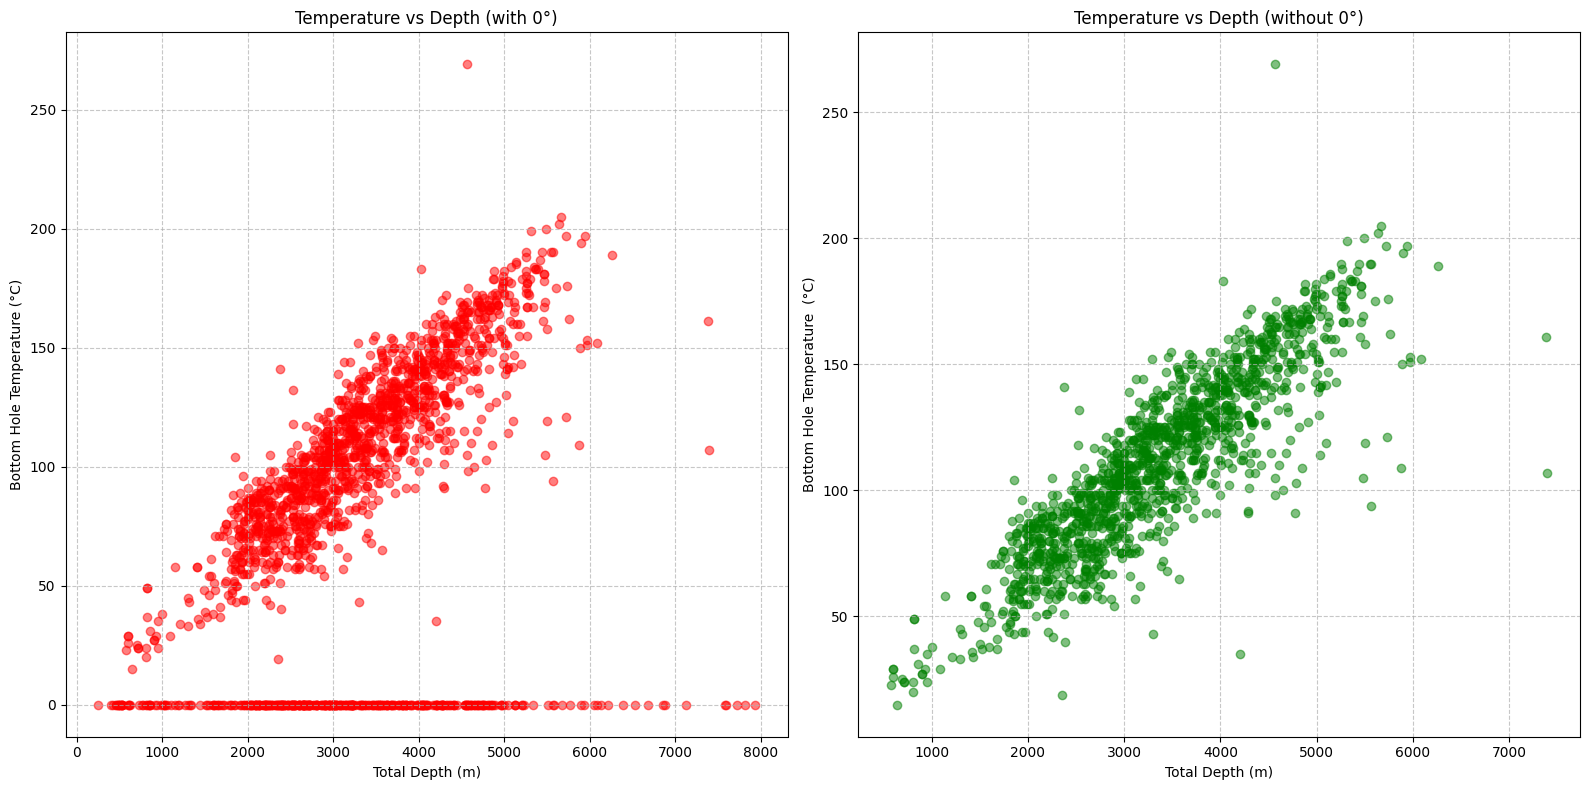

In [37]:
# Créer une figure avec deux subplots côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Premier scatter plot (avec 0°)
ax1.scatter(wells_data['wlbTotalDepth'],
           wells_data['wlbBottomHoleTemperature'],
           alpha=0.5,
           color='red')
ax1.set_xlabel('Total Depth (m)')
ax1.set_ylabel('Bottom Hole Temperature (°C)')
ax1.set_title('Temperature vs Depth (with 0°)')
ax1.grid(True, linestyle='--', alpha=0.7)

# Deuxième scatter plot (sans 0°)
ax2.scatter(wells_data_without_0['wlbTotalDepth'],
           wells_data_without_0['wlbBottomHoleTemperature'],
           alpha=0.5,
           color='green')
ax2.set_xlabel('Total Depth (m)')
ax2.set_ylabel('Bottom Hole Temperature  (°C)')
ax2.set_title('Temperature vs Depth (without 0°)')
ax2.grid(True, linestyle='--', alpha=0.7)

# Ajuster l'espacement entre les plots
plt.tight_layout()

# Afficher le graphique
plt.show()

# Optionnel : sauvegarder la figure
# plt.savefig('comparison_plots.png', dpi=300, bbox_inches='tight')

In [38]:
wells_data_drilling = wells_data[(wells_data['wlbDrillingDays'] > 0) & (wells_data['wlbDrillingDays'] < 800)]

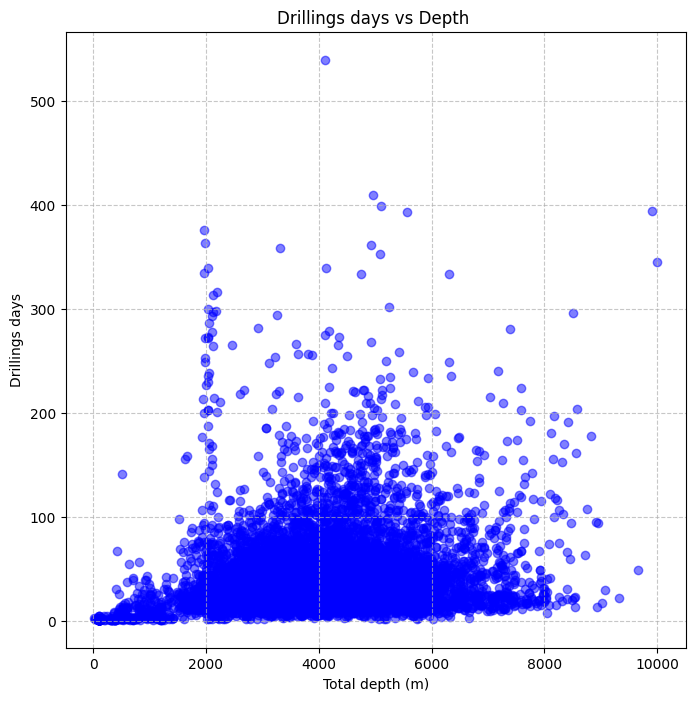

In [40]:
# Créer le scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(wells_data_drilling['wlbTotalDepth'],
           wells_data_drilling['wlbDrillingDays'],
           alpha=0.5,  # transparence
           color='blue')
# Ajouter les labels
plt.xlabel('Total depth (m)')
plt.ylabel('Drillings days')
plt.title('Drillings days vs Depth ')
# Ajouter une grille
plt.grid(True, linestyle='--', alpha=0.7)
# Afficher le graphique
plt.show()

# mean of the total depth according to the "Age At Td"

In [42]:
pd.DataFrame(wells_data.groupby('wlbAgeAtTd')['wlbTotalDepth'].mean()).sort_values("wlbAgeAtTd").round(2).head(10)

,wlbTotalDepth
wlbAgeAtTd,
CAMPANIAN,3574.00
CARBONIFEROUS,3368.50
CRETACEOUS,4449.83
DEVONIAN,4438.00
EARLY CARBONIFEROUS,1767.67
EARLY CRETACEOUS,3251.67
EARLY JURASSIC,3631.92
EARLY PERMIAN,3813.61
EARLY TRIASSIC,3081.32


# Volve Field Production Analysis: Monthly Oil, Gas, and Water Trends (NPD Code 7405)

In [44]:
monthly['year_month'] = pd.to_datetime(monthly[['Year', 'Month']].assign(DAY=1))
monthly['year_month'] = monthly['year_month'].dt.strftime('%Y-%m')

In [45]:
monthly

,Wellbore name,NPDCode,Year,Month,On Stream (hrs),Oil (Sm3),Gas (Sm3),Water (Sm3),GI (Sm3),WI (Sm3),year_month
0,15/9-F-1 C,7405,2014,4,227.50000,11142.47,1597936.65,0.00,NaN,NaN,2014-04
1,15/9-F-1 C,7405,2014,5,733.83334,24901.95,3496229.65,783.48,NaN,NaN,2014-05
2,15/9-F-1 C,7405,2014,6,705.91666,19617.76,2886661.69,2068.48,NaN,NaN,2014-06
3,15/9-F-1 C,7405,2014,7,742.41666,15085.68,2249365.75,6243.98,NaN,NaN,2014-07
4,15/9-F-1 C,7405,2014,8,432.99166,6970.43,1048190.80,4529.75,NaN,NaN,2014-08
...,...,...,...,...,...,...,...,...,...,...,...
521,15/9-F-5,5769,2016,5,732.00000,9724.40,1534677.16,3949.90,NaN,0.0,2016-05
522,15/9-F-5,5769,2016,6,718.41667,9121.48,1468557.12,2376.93,NaN,NaN,2016-06
523,15/9-F-5,5769,2016,7,668.64168,9985.29,1602674.39,2453.71,NaN,0.0,2016-07
524,15/9-F-5,5769,2016,8,608.42500,8928.90,1417278.51,2371.86,NaN,0.0,2016-08


The table below shows the creation of a new 'year_month' variable in YY-MM format

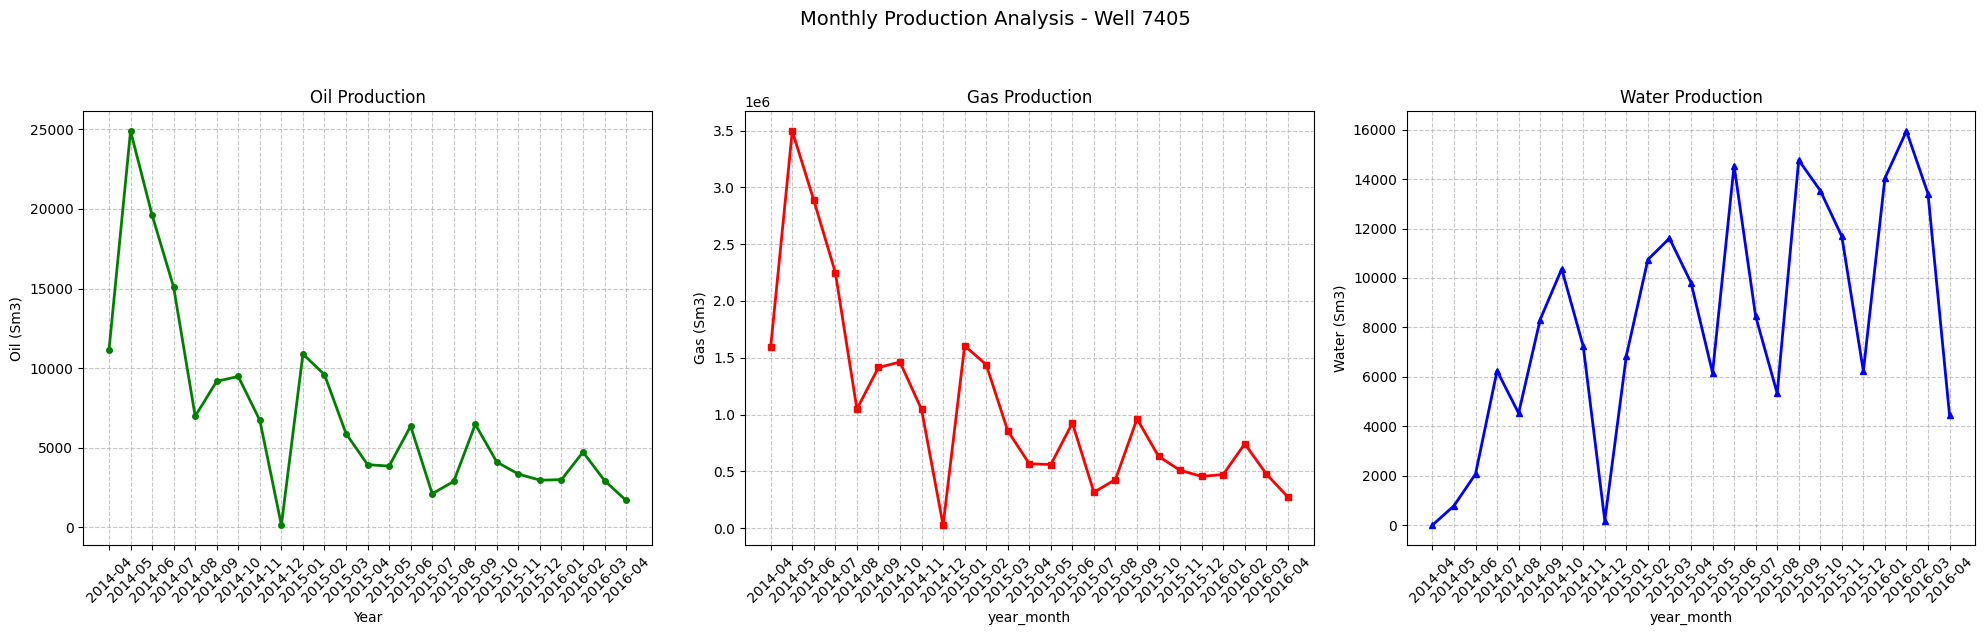

In [46]:
import matplotlib.pyplot as plt

# Filtrer les données pour NPDCode = 7405
monthly_7405 = monthly[monthly['NPDCode'] == 7405]

# Créer une figure avec trois subplots côte à côte
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Oil Production
ax1.plot(monthly_7405['year_month'], monthly_7405['Oil (Sm3)'],
         marker='o', color='green', linewidth=2, markersize=4)
ax1.set_title('Oil Production', fontsize=12)
ax1.set_xlabel('Year', fontsize=10)
ax1.set_ylabel('Oil (Sm3)', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Gas Production
ax2.plot(monthly_7405['year_month'], monthly_7405['Gas (Sm3)'],
         marker='s', color='red', linewidth=2, markersize=4)
ax2.set_title('Gas Production', fontsize=12)
ax2.set_xlabel('year_month', fontsize=10)
ax2.set_ylabel('Gas (Sm3)', fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Water Production
ax3.plot(monthly_7405['year_month'], monthly_7405['Water (Sm3)'],
         marker='^', color='blue', linewidth=2, markersize=4)
ax3.set_title('Water Production', fontsize=12)
ax3.set_xlabel('year_month', fontsize=10)
ax3.set_ylabel('Water (Sm3)', fontsize=10)
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.tick_params(axis='x', rotation=45)

# Titre général
plt.suptitle('Monthly Production Analysis - Well 7405', fontsize=14, y=1.05)

# Ajuster l'espacement
plt.tight_layout()

# Afficher le graphique
plt.show()


In [47]:
#pd.DataFrame(monthly.groupby('NPDCode')['Oil (Sm3)'].sum()).sort_values('Oil (Sm3)')

In [57]:
oil_by_volve = pd.DataFrame(monthly.groupby('Wellbore name')['Oil (Sm3)'].sum()).reset_index()
oil_by_volve

,Wellbore name,Oil (Sm3)
0,15/9-F-1 C,177709.33
1,15/9-F-11,1147849.10
2,15/9-F-12,4579609.55
3,15/9-F-14,3942233.39
4,15/9-F-15 D,148518.56
5,15/9-F-4,0.00
6,15/9-F-5,41160.68


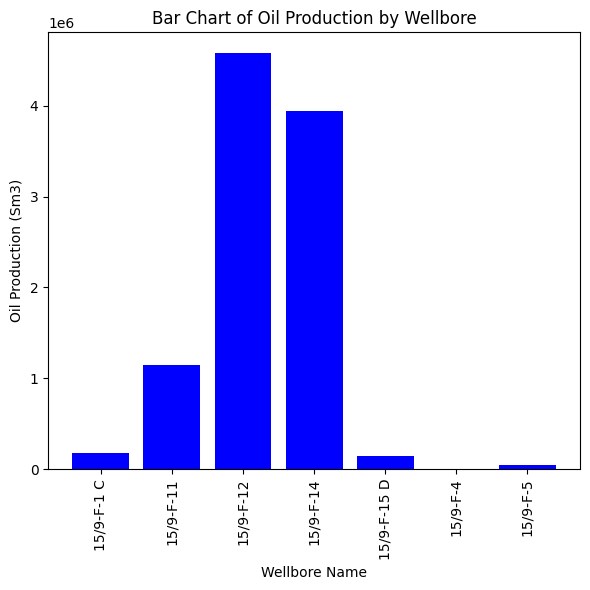

In [61]:
#How to do a pie chart  oil by volve
# Create a bar chart with different colors for each bar
plt.figure(figsize=(6, 6))
plt.bar(oil_by_volve['Wellbore name'], oil_by_volve['Oil (Sm3)'], color='blue')
plt.xlabel('Wellbore Name')
plt.ylabel('Oil Production (Sm3)')
plt.title('Bar Chart of Oil Production by Volve')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()




#### Merged Data

In [78]:
wells_data['wlbTotalDepthcolumns']

KeyError: 'wlbTotalDepthcolumns'

In [81]:
cols_to_keep = ['wlbWellboreName','wlbTotalDepth']
partial_wells_data = wells_data[cols_to_keep]

In [82]:
cols_to_keep1 = ['Wellbore name','Oil (Sm3)','Gas (Sm3)','Water (Sm3)']
partial = monthly[cols_to_keep1]

In [84]:
# making a sum aggregation grouping by the common column 'Wellbore name'
partial_mpd = partial.groupby('Wellbore name').sum().reset_index()
partial_mpd

,Wellbore name,Oil (Sm3),Gas (Sm3),Water (Sm3)
0,15/9-F-1 C,177709.33,2.644092e+07,207302.39
1,15/9-F-11,1147849.10,1.743105e+08,1090806.27
2,15/9-F-12,4579609.55,6.675423e+08,6833320.37
3,15/9-F-14,3942233.39,5.780095e+08,7121249.74
4,15/9-F-15 D,148518.56,2.250535e+07,52366.40
5,15/9-F-4,0.00,0.000000e+00,0.00
6,15/9-F-5,41160.68,6.561826e+06,13533.18


In [85]:
merged_data = partial_wells_data.merge(
    partial_mpd,
    left_on='wlbWellboreName',
    right_on='Wellbore name',
    how='inner'
)

In [86]:
merged_data

,wlbWellboreName,wlbTotalDepth,Wellbore name,Oil (Sm3),Gas (Sm3),Water (Sm3)
0,15/9-F-14,3750.0,15/9-F-14,3942233.39,5.780095e+08,7121249.74
1,15/9-F-12,3520.0,15/9-F-12,4579609.55,6.675423e+08,6833320.37
2,15/9-F-4,3510.0,15/9-F-4,0.00,0.000000e+00,0.00
3,15/9-F-5,3792.0,15/9-F-5,41160.68,6.561826e+06,13533.18
4,15/9-F-11,4562.0,15/9-F-11,1147849.10,1.743105e+08,1090806.27
5,15/9-F-15 D,4685.0,15/9-F-15 D,148518.56,2.250535e+07,52366.40
6,15/9-F-1 C,4094.0,15/9-F-1 C,177709.33,2.644092e+07,207302.39


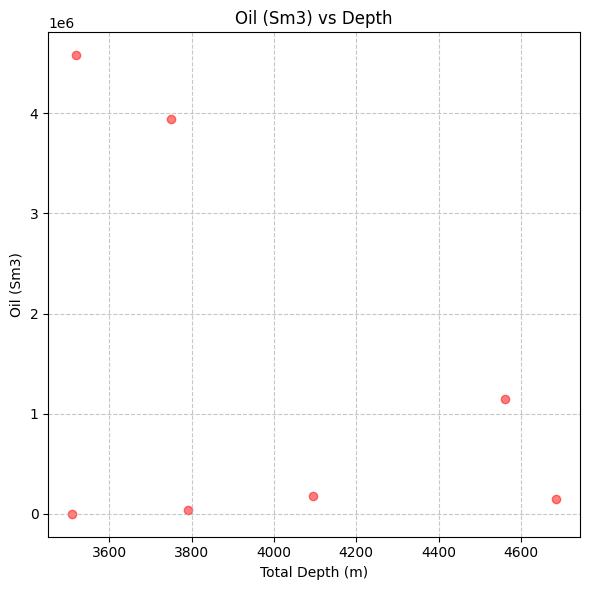

In [87]:
# Créer une figure avec deux subplots côte à côte
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

# Premier scatter plot (avec 0°)
ax1.scatter(merged_data['wlbTotalDepth'],
           merged_data['Oil (Sm3)'],
           alpha=0.5,
           color='red')
ax1.set_xlabel('Total Depth (m)')
ax1.set_ylabel('Oil (Sm3)')
ax1.set_title('Oil (Sm3) vs Depth')
ax1.grid(True, linestyle='--', alpha=0.7)



# Ajuster l'espacement entre les plots
plt.tight_layout()

# Afficher le graphique
plt.show()

In [90]:
# value of correlation betweeen  wlbTotalDepth and  Oil (Sm3) in merged_data
merged_data[['wlbTotalDepth','Oil (Sm3)']].corr(method='pearson').iloc[0,1]

-0.4062457634729381

Negative correlation between deepth and oil, we can calculate pearson coeffecient